In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def svm_evaluation(model, X, y):
    preds = model.predict(X)

    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds)
    rec = recall_score(y, preds)
    f1 = f1_score(y, preds)

    return acc, prec, rec, f1

In [10]:
rm_features = [
    'IOP', 'SBP', 'DBP', 'HR', 'P1', 'P4', 'P5', 'R4', 'R5', 'hypertension', 'hyperlipidaemia1', 'age', 'bmi', 'chol', 'bldglu'
]

data_dir = '../data/seed/'
plot_dir =  data_dir + 'SSL_results/'

data = pd.read_csv(data_dir + 'SEED_progression_enhanced.csv')

labeled_X = data.copy()
labeled_X = labeled_X[labeled_X['func_progression'] != -1].reset_index(drop=True)

unlabeled_Xs = data.copy()
unlabeled_Xs = unlabeled_Xs[unlabeled_Xs['func_progression'] == -1].reset_index(drop=True)

labeled_X, labels = labeled_X[rm_features], labeled_X['func_progression']
unlabeled_Xs = unlabeled_Xs[rm_features]

split = int(0.9 * len(labeled_X))
labeled_X, test_X = labeled_X[:split], labeled_X[split:]
labels, test_labels = labels[:split], labels[split:]

labeled_X

/tmp/ipykernel_71609/3209328377.py:8: DtypeWarning: Columns (97,99,153,155,181,183,209,211,306,307,308,362,363,364,391,392,393,420,421,422) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_dir + 'SEED_progression_enhanced.csv')


,IOP,SBP,DBP,HR,P1,P4,P5,R4,R5,hypertension,hyperlipidaemia1,age,bmi,chol,bldglu
0,14.0,160.5,89.000000,82.000000,54.353404,24.467735,20.920736,3958.933240,2230.158494,1.0,1.0,52.859685,29.714286,7.48,5.9
1,17.0,150.5,71.666667,82.666667,50.612120,23.680001,20.146534,4867.423344,2236.001740,1.0,0.0,75.353867,28.461798,5.10,18.1
2,17.0,132.5,78.500000,65.000000,46.617885,22.671671,19.437524,5146.392218,2237.120771,1.0,1.0,63.928816,29.696945,6.40,22.6
3,21.0,138.0,71.000000,95.500000,48.432416,24.941110,19.296306,5678.779132,4768.998472,0.0,1.0,61.245722,22.735275,6.54,15.5
4,13.0,143.0,67.500000,73.333333,48.062857,22.853702,19.825284,4093.769151,2230.304842,1.0,0.0,64.459959,30.953251,5.46,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,15.0,137.5,85.000000,75.666667,48.285942,23.001186,19.797961,4514.028046,2233.415861,0.0,0.0,58.527036,25.370370,5.74,6.2
2412,19.0,140.0,85.500000,77.000000,49.365648,23.652686,19.811060,5446.970413,2509.629808,1.0,0.0,50.819986,25.899774,4.90,7.3
2413,16.0,139.0,87.500000,81.000000,48.953945,23.217511,19.882111,4710.895898,2234.841903,0.0,0.0,57.765914,23.595456,5.93,6.6
2414,18.0,135.0,71.500000,58.500000,46.772244,22.839647,19.417482,5408.158493,2399.626874,1.0,1.0,53.642710,22.582709,4.85,6.4


In [11]:
percentages = np.arange(0, 1.1, 0.1).tolist()

accuracys, precisions, recalls, f1s = [], [], [], []
for percent in percentages:
    print(f"{percent*100}% unlabeled")
    split = int(len(unlabeled_Xs)*percent)
    unlabeled_X = unlabeled_Xs[:split]

    # svm = SVC(C=10.0, kernel='rbf', gamma='auto', probability=True)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

    if len(unlabeled_X) > 0:
        thresh = np.arange(0, 1, 0.025).tolist()[::-1]

        epoch = 0
        with tqdm(total=len(unlabeled_X)) as pbar:
            while True:
                # svm.fit(labeled_X, labels)
                xgb.fit(labeled_X, labels)

                if len(unlabeled_X) == 0:
                    print("Finished")
                    break

                # probabilities = svm.predict_proba(unlabeled_X)
                # psuedo_labels = svm.predict(unlabeled_X)

                probabilities = xgb.predict_proba(unlabeled_X)
                psuedo_labels = xgb.predict(unlabeled_X)

                strong_preds, thresh_count = [], 0
                while True not in strong_preds:
                    strong_preds = np.max(probabilities, axis=1) > thresh[thresh_count]
                    thresh_count += 1
                
                new_y = psuedo_labels[strong_preds]
                new_X = unlabeled_X[strong_preds]
                
                labels = np.hstack([labels, new_y])
                labeled_X = np.vstack([labeled_X, new_X])

                unlabeled_X = unlabeled_X[~strong_preds]

                pbar.update(len(new_X))
                epoch += 1
    else:
        # svm.fit(labeled_X, labels)
        xgb.fit(labeled_X, labels)
    
    # acc, prec, rec, f1 = svm_evaluation(svm, test_X, test_labels)
    acc, prec, rec, f1 = svm_evaluation(xgb, test_X, test_labels)
    accuracys.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

0.0% unlabeled
10.0% unlabeled


100%|██████████| 1072/1072 [02:00<00:00,  8.91it/s]


Finished
20.0% unlabeled


100%|██████████| 2145/2145 [02:03<00:00, 17.42it/s] 


Finished
30.000000000000004% unlabeled


100%|██████████| 3218/3218 [02:40<00:00, 20.07it/s]  


Finished
40.0% unlabeled


100%|██████████| 4291/4291 [03:35<00:00, 19.93it/s]  


Finished
50.0% unlabeled


100%|██████████| 5364/5364 [03:59<00:00, 22.37it/s]  


Finished
60.00000000000001% unlabeled


100%|██████████| 6436/6436 [03:06<00:00, 34.46it/s]  


Finished
70.0% unlabeled


100%|██████████| 7509/7509 [03:35<00:00, 34.90it/s]  


Finished
80.0% unlabeled


100%|██████████| 8582/8582 [05:46<00:00, 24.77it/s]  


Finished
90.0% unlabeled


100%|██████████| 9655/9655 [05:00<00:00, 32.15it/s]  


Finished
100.0% unlabeled


100%|██████████| 10728/10728 [06:21<00:00, 28.11it/s]  

Finished


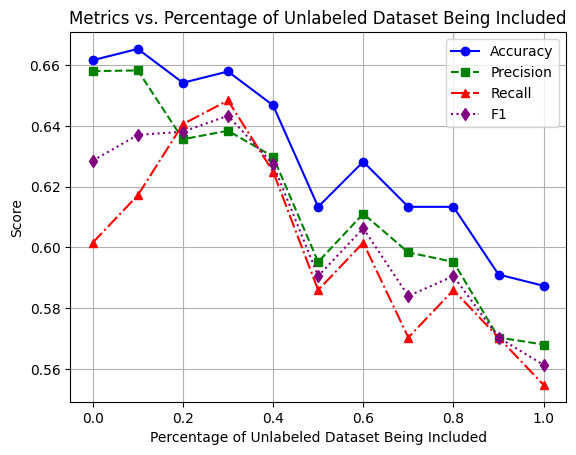

In [12]:
plt.plot(percentages, accuracys, color='blue', marker='o', linestyle='-', label="Accuracy")
plt.plot(percentages, precisions, color='green', marker='s', linestyle='--', label="Precision")
plt.plot(percentages, recalls, color='red', marker='^', linestyle='-.', label="Recall")
plt.plot(percentages, f1s, color='purple', marker='d', linestyle=':', label="F1")

plt.xlabel("Percentage of Unlabeled Dataset Being Included")
plt.ylabel("Score")
plt.title("Metrics vs. Percentage of Unlabeled Dataset Being Included")
plt.legend()
plt.grid(True)
plt.savefig(plot_dir + "xgb_metrics.png")
plt.show()